In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit, minimize
from sympy import symbols, diff, simplify
import json
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Bibliotheken erfolgreich importiert!")

Bibliotheken erfolgreich importiert!


In [14]:
with open('../../data/processed/swiss_rental_data_m2_room_count/Durchscnittlicher_Mietpreis_m2_Zimmerzahl_Kanton_combined.json', 'r', encoding='utf-8') as f:
    room_data = json.load(f)

def flatten_room_data(json_data):
    flat_data = {
        "year": [],
        "canton": [],
        "room_count": [],
        "avg_price_per_sqm": [],
        "confidence_interval": []
    }
    
    for item in json_data:
        for room in item.get("room_categories", []):
            flat_data["year"].append(item.get("year"))
            flat_data["canton"].append(item.get("canton"))
            flat_data["room_count"].append(room.get("room_count"))
            flat_data["avg_price_per_sqm"].append(room.get("avg_price_per_sqm"))
            flat_data["confidence_interval"].append(room.get("confidence_interval"))
    
    return pd.DataFrame(flat_data)

room_df = flatten_room_data(room_data)
room_df['year'] = pd.to_numeric(room_df['year'], errors='ignore')
room_df['room_count_num'] = room_df['room_count'].apply(
    lambda x: float(str(x).replace('+', '')) if pd.notna(x) else np.nan
)

latest_year = max(room_df['year'])
latest_df = room_df[room_df['year'] == latest_year]

print(f"Daten geladen für Jahr {latest_year}")

Daten geladen für Jahr 2023


C:\Users\Nevin\AppData\Local\Temp\ipykernel_5888\3906303372.py:24: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  room_df['year'] = pd.to_numeric(room_df['year'], errors='ignore')


In [15]:
typical_sizes = {
    '1': 35,
    '2': 55,
    '3': 75,
    '4': 95,
    '5': 120,
    '5+': 130,
    '6': 150,
    '6+': 160
}

cost_data = []

for room_group in latest_df.groupby('room_count'):
    room_count = room_group[0]
    avg_price = room_group[1]['avg_price_per_sqm'].mean()
    
    if room_count in typical_sizes:
        size = typical_sizes[room_count]
        total_rent = avg_price * size
        cost_data.append({
            'room_count': room_count,
            'room_count_num': float(str(room_count).replace('+', '')),
            'apartment_size': size,
            'price_per_sqm': avg_price,
            'total_monthly_rent': total_rent
        })

cost_df = pd.DataFrame(cost_data)
cost_df = cost_df.sort_values('apartment_size')

print("Wohnungsgrössen und Kosten:")
display(cost_df)

Wohnungsgrössen und Kosten:


,room_count,room_count_num,apartment_size,price_per_sqm,total_monthly_rent
0,1,1.0,35,19.442308,680.480769
1,2,2.0,55,17.970370,988.370370
2,3,3.0,75,16.270370,1220.277778
3,4,4.0,95,15.288889,1452.444444
4,5,5.0,120,14.914815,1789.777778
5,6+,6.0,160,15.459259,2473.481481


In [ ]:
def cost_function(x, a, b, c):
    return a * x**2 + b * x + c

params, covariance = curve_fit(
    cost_function, 
    cost_df['apartment_size'], 
    cost_df['total_monthly_rent'],
    p0=[0.01, 10, 100]
)

a_original, b_original, c_original = params

a = round(a_original, 3)
b = round(b_original, 1)
c = round(c_original, 0)

print(f"Original Parameter: a = {a_original:.6f}, b = {b_original:.4f}, c = {c_original:.2f}")
print(f"Generalisierte Kostenfunktion: K(m²) = {a:.3f}·m²² + {b:.1f}·m² + {c:.0f}")

y_actual = cost_df['total_monthly_rent']
y_pred = cost_function(cost_df['apartment_size'], a, b, c)
ss_total = np.sum((y_actual - np.mean(y_actual))**2)
ss_residual = np.sum((y_actual - y_pred)**2)
r_squared = 1 - (ss_residual / ss_total)
print(f"R² Wert mit generalisierten Parametern: {r_squared:.4f}")

Kostenfunktion: K(m²) = 0.022083·m²² + 9.6461·m² + 349.20
R² Wert: 0.9975


In [17]:
def benefit_function(x, scale=10, exponent=0.7, min_size=15):
    return scale * (x - min_size + 1)**exponent

def benefit_derivative(x, scale=10, exponent=0.7, min_size=15):
    return scale * exponent * (x - min_size + 1)**(exponent-1)

def marginal_cost_function(x):
    return 2 * a * x + b

def cost_per_benefit(x):
    if x <= 15:
        return float('inf')
    return cost_function(x, a, b, c) / benefit_function(x)

print("Nutzenfunktion: N(m²) = 10·(m²-15+1)^0.7")
print("Grenzkosten: K'(m²) = 2a·m² + b")

Nutzenfunktion: N(m²) = 10·(m²-15+1)^0.7
Grenzkosten: K'(m²) = 2a·m² + b


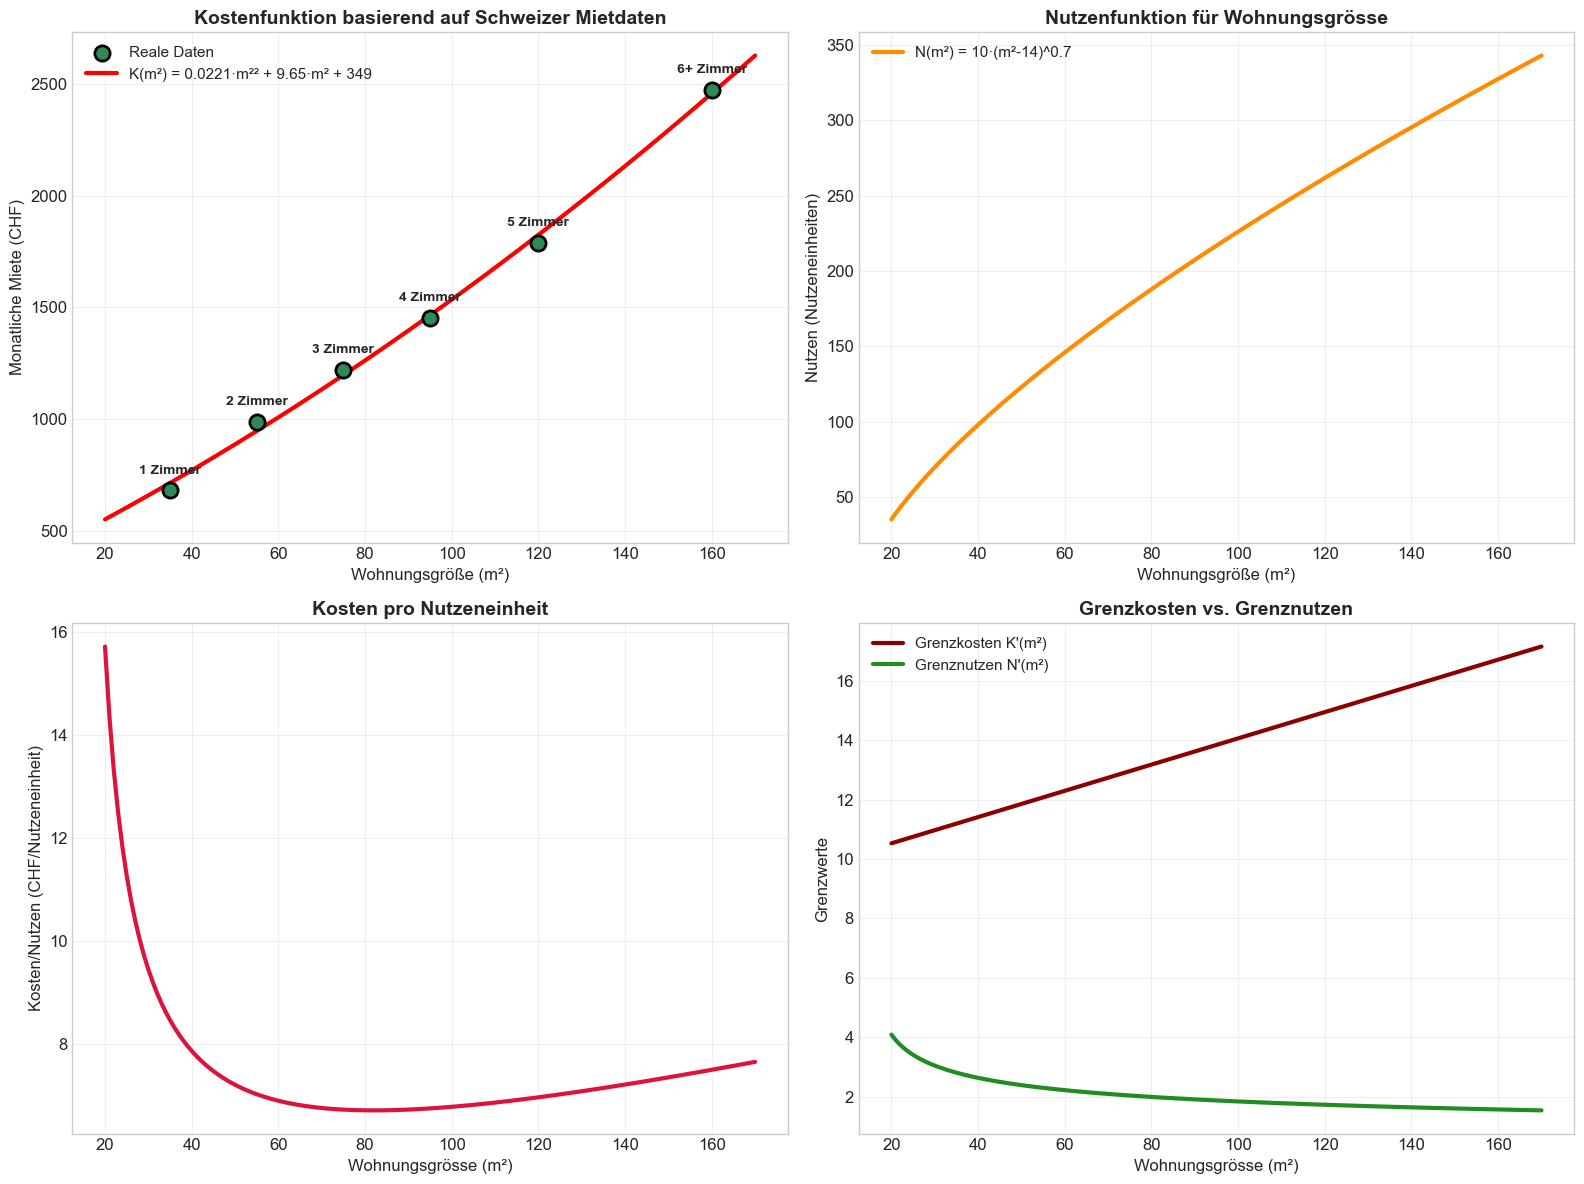

In [ ]:
apartment_sizes = np.linspace(20, 170, 150)
predicted_costs = cost_function(apartment_sizes, a, b, c)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0,0].scatter(cost_df['apartment_size'], cost_df['total_monthly_rent'], 
                 s=120, color='#2E8B57', edgecolor='black', linewidth=2, 
                 label='Reale Daten', zorder=5)

for i, row in cost_df.iterrows():
    axes[0,0].annotate(f"{row['room_count']} Zimmer", 
                      (row['apartment_size'], row['total_monthly_rent']),
                      textcoords="offset points", 
                      xytext=(0, 12), 
                      ha='center', fontsize=10, fontweight='bold')

axes[0,0].plot(apartment_sizes, predicted_costs, 'r-', linewidth=3, 
              label=f'K(m²) = {a:.3f}·m²² + {b:.1f}·m² + {c:.0f}')

axes[0,0].set_title('Kostenfunktion basierend auf Schweizer Mietdaten', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Wohnungsgröße (m²)', fontsize=12)
axes[0,0].set_ylabel('Monatliche Miete (CHF)', fontsize=12)
axes[0,0].grid(True, alpha=0.3)
axes[0,0].legend(fontsize=11)

axes[0,1].plot(apartment_sizes, benefit_function(apartment_sizes), 
              color='#FF8C00', linewidth=3, label='N(m²) = 10·(m²-14)^0.7')
axes[0,1].set_title('Nutzenfunktion für Wohnungsgrösse', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Wohnungsgröße (m²)', fontsize=12)
axes[0,1].set_ylabel('Nutzen (Nutzeneinheiten)', fontsize=12)
axes[0,1].grid(True, alpha=0.3)
axes[0,1].legend(fontsize=11)

cpb_values = [cost_per_benefit(x) for x in apartment_sizes]
axes[1,0].plot(apartment_sizes, cpb_values, color='#DC143C', linewidth=3)
axes[1,0].set_title('Kosten pro Nutzeneinheit', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Wohnungsgrösse (m²)', fontsize=12)
axes[1,0].set_ylabel('Kosten/Nutzen (CHF/Nutzeneinheit)', fontsize=12)
axes[1,0].grid(True, alpha=0.3)

marginal_costs = [marginal_cost_function(x) for x in apartment_sizes]
marginal_benefits = [benefit_derivative(x) for x in apartment_sizes]

axes[1,1].plot(apartment_sizes, marginal_costs, color='#8B0000', linewidth=3, label='Grenzkosten K\'(m²)')
axes[1,1].plot(apartment_sizes, marginal_benefits, color='#228B22', linewidth=3, label='Grenznutzen N\'(m²)')
axes[1,1].set_title('Grenzkosten vs. Grenznutzen', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Wohnungsgrösse (m²)', fontsize=12)
axes[1,1].set_ylabel('Grenzwerte', fontsize=12)
axes[1,1].grid(True, alpha=0.3)
axes[1,1].legend(fontsize=11)

plt.tight_layout()
plt.show()

In [19]:
result = minimize(cost_per_benefit, x0=50, bounds=[(15, 200)])
optimal_size = result.x[0]
minimum_ratio = result.fun

optimal_cost = cost_function(optimal_size, a, b, c)
optimal_benefit = benefit_function(optimal_size)
optimal_marginal_cost = marginal_cost_function(optimal_size)
optimal_marginal_benefit = benefit_derivative(optimal_size)

ratio1 = optimal_marginal_cost / optimal_marginal_benefit
ratio2 = optimal_cost / optimal_benefit

closest_room = min(typical_sizes.items(), key=lambda x: abs(float(x[1]) - optimal_size))

print(f"Optimale Wohnungsgrösse: {optimal_size:.2f} m²")
print(f"Minimales Kosten/Nutzen-Verhältnis: {minimum_ratio:.2f} CHF/Nutzeneinheit")
print(f"Entspricht am ehesten einer {closest_room[0]}-Zimmer-Wohnung")
print(f"\nVerifikation der analytischen Lösung:")
print(f"K'(m²)/N'(m²) = {ratio1:.2f}")
print(f"K(m²)/N(m²) = {ratio2:.2f}")
print(f"Differenz: {abs(ratio1 - ratio2):.4f}")

Optimale Wohnungsgrösse: 81.98 m²
Minimales Kosten/Nutzen-Verhältnis: 6.72 CHF/Nutzeneinheit
Entspricht am ehesten einer 3-Zimmer-Wohnung

Verifikation der analytischen Lösung:
K'(m²)/N'(m²) = 6.72
K(m²)/N(m²) = 6.72
Differenz: 0.0001


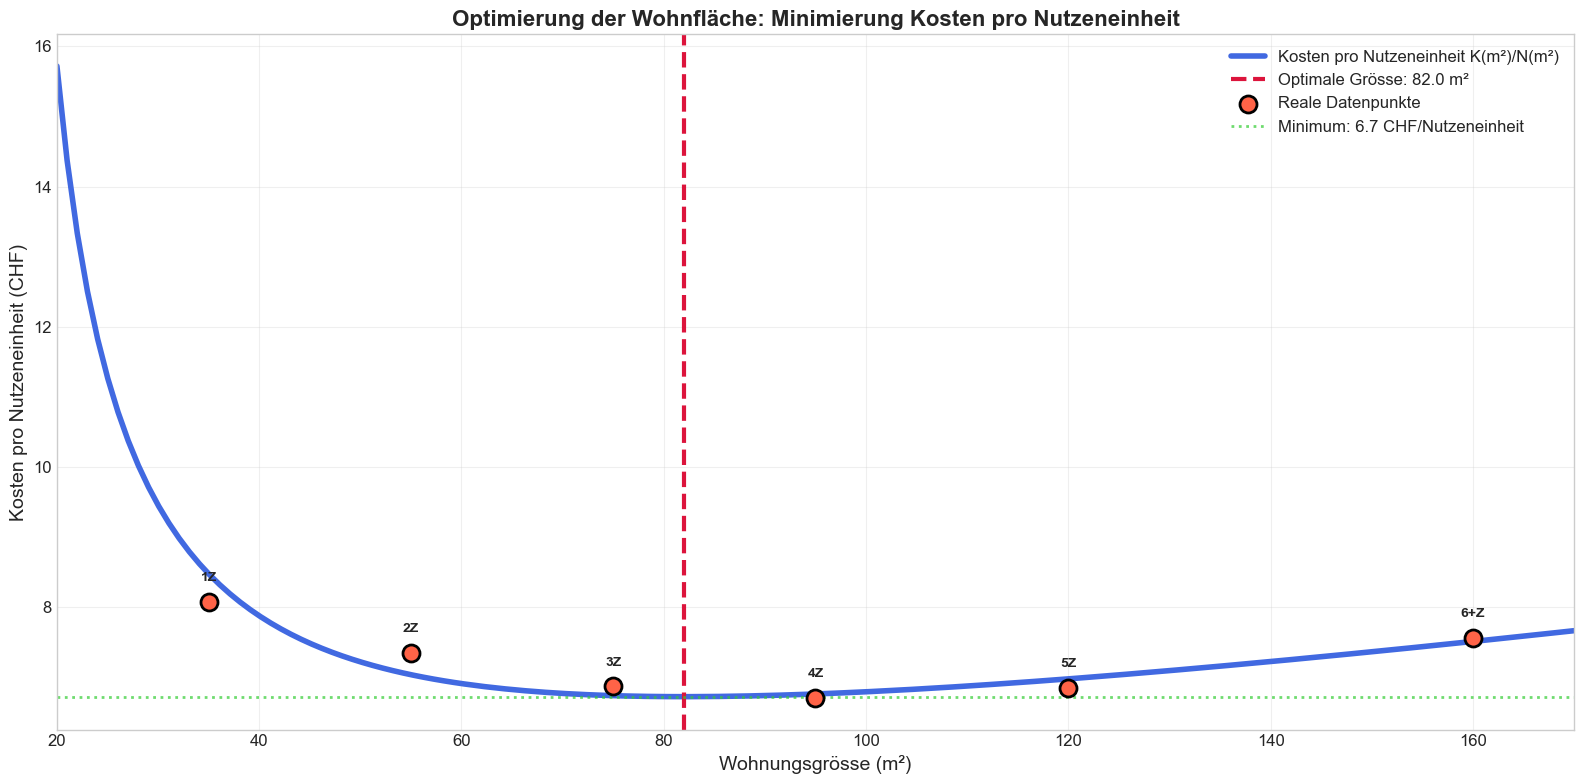

In [20]:
plt.figure(figsize=(16, 8))

costs = np.array([cost_function(x, a, b, c) for x in apartment_sizes])
benefits = np.array([benefit_function(x) for x in apartment_sizes])
cost_benefit_ratios = costs / benefits

plt.plot(apartment_sizes, cost_benefit_ratios, color='#4169E1', linewidth=4, 
         label='Kosten pro Nutzeneinheit K(m²)/N(m²)')

plt.axvline(x=optimal_size, color='#DC143C', linestyle='--', linewidth=3,
            label=f'Optimale Grösse: {optimal_size:.1f} m²')

actual_ratios = cost_df['total_monthly_rent'] / benefit_function(cost_df['apartment_size'])
plt.scatter(cost_df['apartment_size'], actual_ratios, 
            s=150, color='#FF6347', edgecolor='black', linewidth=2, 
            label='Reale Datenpunkte', zorder=5)

for i, row in cost_df.iterrows():
    plt.annotate(f"{row['room_count']}Z", 
                (row['apartment_size'], actual_ratios.iloc[i]),
                textcoords="offset points", 
                xytext=(0, 15), 
                ha='center', fontsize=10, fontweight='bold')

plt.axhline(y=minimum_ratio, color='#32CD32', linestyle=':', linewidth=2, alpha=0.7,
            label=f'Minimum: {minimum_ratio:.1f} CHF/Nutzeneinheit')

plt.title('Optimierung der Wohnfläche: Minimierung Kosten pro Nutzeneinheit', fontsize=16, fontweight='bold')
plt.xlabel('Wohnungsgrösse (m²)', fontsize=14)
plt.ylabel('Kosten pro Nutzeneinheit (CHF)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12, loc='upper right')
plt.xlim(20, 170)
plt.tight_layout()
plt.show()

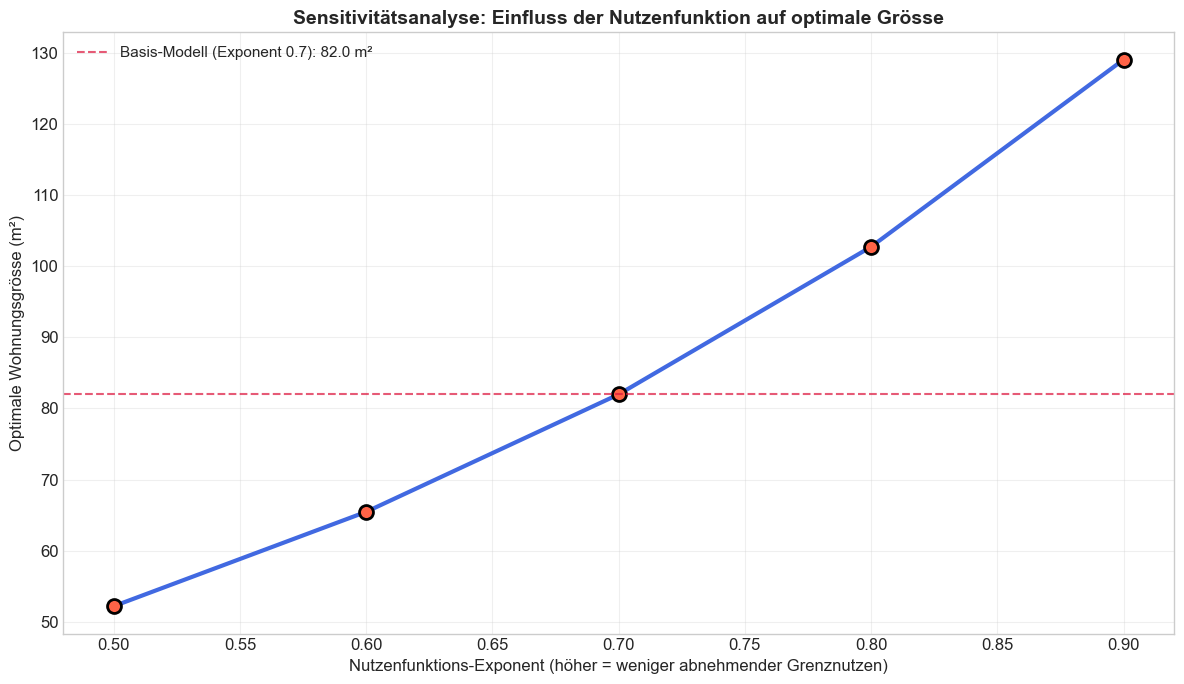

Sensitivitätsanalyse Ergebnisse:
Exponent = 0.5: Optimale Grösse = 52.2 m²
Exponent = 0.6: Optimale Grösse = 65.5 m²
Exponent = 0.7: Optimale Grösse = 82.0 m²
Exponent = 0.8: Optimale Grösse = 102.7 m²
Exponent = 0.9: Optimale Grösse = 129.1 m²


In [21]:
exponents = np.array([0.5, 0.6, 0.7, 0.8, 0.9])
optimal_sizes = []

for exponent in exponents:
    def cpb(x, exp=exponent):
        if x <= 15:
            return float('inf')
        return cost_function(x, a, b, c) / (10 * (x - 15 + 1)**exp)
    
    result = minimize(cpb, x0=50, bounds=[(15, 200)])
    optimal_sizes.append(result.x[0])

plt.figure(figsize=(12, 7))
plt.plot(exponents, optimal_sizes, 'o-', linewidth=3, markersize=10, 
         color='#4169E1', markerfacecolor='#FF6347', markeredgecolor='black', markeredgewidth=2)

plt.axhline(y=optimal_size, color='#DC143C', linestyle='--', alpha=0.7,
            label=f'Basis-Modell (Exponent 0.7): {optimal_size:.1f} m²')

plt.title('Sensitivitätsanalyse: Einfluss der Nutzenfunktion auf optimale Grösse', fontsize=14, fontweight='bold')
plt.xlabel('Nutzenfunktions-Exponent (höher = weniger abnehmender Grenznutzen)', fontsize=12)
plt.ylabel('Optimale Wohnungsgrösse (m²)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

print("Sensitivitätsanalyse Ergebnisse:")
for i, exponent in enumerate(exponents):
    print(f"Exponent = {exponent}: Optimale Grösse = {optimal_sizes[i]:.1f} m²")

In [22]:
sizes_to_compare = [35, 55, 75, 95, 120, 150]
comparison_data = []

for size in sizes_to_compare:
    cost = cost_function(size, a, b, c)
    benefit = benefit_function(size)
    ratio = cost / benefit
    
    closest_room = min(typical_sizes.items(), key=lambda x: abs(float(x[1]) - size))
    
    comparison_data.append({
        'apartment_size': size,
        'room_count': closest_room[0],
        'monthly_rent': cost,
        'benefit': benefit,
        'cost_per_benefit': ratio,
        'efficiency_ratio': minimum_ratio / ratio
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('apartment_size')

print("Kosteneffizienz-Vergleich verschiedener Wohnungsgrössen:")
display(comparison_df)

Kosteneffizienz-Vergleich verschiedener Wohnungsgrössen:


,apartment_size,room_count,monthly_rent,benefit,cost_per_benefit,efficiency_ratio
0,35,1,713.869348,84.246818,8.473547,0.793088
1,55,2,946.541841,134.570139,7.033818,0.955423
2,75,3,1196.880984,177.717782,6.734728,0.997853
3,95,4,1464.886779,216.740222,6.758721,0.994311
4,120,5,1824.737750,261.646004,6.974071,0.963608
5,150,6,2292.996382,311.513761,7.360819,0.912978


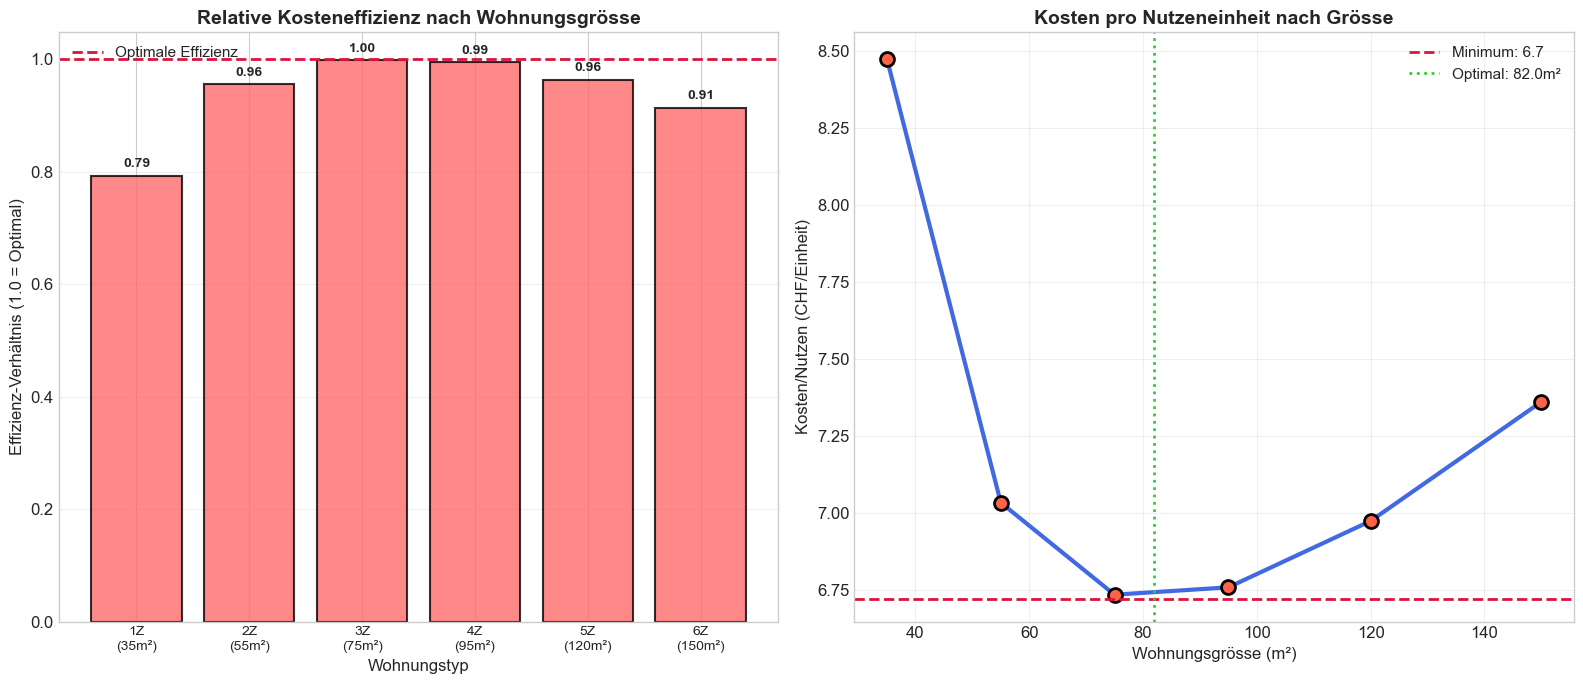

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

colors = ['#FF6B6B' if x < 1.0 else '#4ECDC4' for x in comparison_df['efficiency_ratio']]

bars1 = ax1.bar(range(len(comparison_df)), comparison_df['efficiency_ratio'], 
               color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)

ax1.axhline(y=1.0, color='#DC143C', linestyle='--', linewidth=2, label='Optimale Effizienz')
ax1.set_title('Relative Kosteneffizienz nach Wohnungsgrösse', fontsize=14, fontweight='bold')
ax1.set_xlabel('Wohnungstyp', fontsize=12)
ax1.set_ylabel('Effizienz-Verhältnis (1.0 = Optimal)', fontsize=12)
ax1.set_xticks(range(len(comparison_df)))
ax1.set_xticklabels([f"{row['room_count']}Z\n({row['apartment_size']}m²)" 
                    for _, row in comparison_df.iterrows()], fontsize=10)
ax1.grid(axis='y', alpha=0.3)
ax1.legend(fontsize=11)

for i, (bar, value) in enumerate(zip(bars1, comparison_df['efficiency_ratio'])):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{value:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

ax2.plot(comparison_df['apartment_size'], comparison_df['cost_per_benefit'], 
         'o-', linewidth=3, markersize=10, color='#4169E1', 
         markerfacecolor='#FF6347', markeredgecolor='black', markeredgewidth=2)

ax2.axhline(y=minimum_ratio, color='#DC143C', linestyle='--', linewidth=2, 
           label=f'Minimum: {minimum_ratio:.1f}')
ax2.axvline(x=optimal_size, color='#32CD32', linestyle=':', linewidth=2, 
           label=f'Optimal: {optimal_size:.1f}m²')

ax2.set_title('Kosten pro Nutzeneinheit nach Grösse', fontsize=14, fontweight='bold')
ax2.set_xlabel('Wohnungsgrösse (m²)', fontsize=12)
ax2.set_ylabel('Kosten/Nutzen (CHF/Einheit)', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=11)

plt.tight_layout()
plt.show()

In [ ]:
print("="*70)
print("OPTIMIERUNG DER WOHNFLÄCHE: ZUSAMMENFASSUNG")
print("="*70)

print(f"\nMATHEMATISCHER ANSATZ:")
print(f"• Kostenfunktion: K(m²) = {a:.3f}·m²² + {b:.1f}·m² + {c:.0f}")
print(f"• Nutzenfunktion: N(m²) = 10·(m²-14)^0.7")
print(f"• Optimierung: Minimierung von K(m²)/N(m²)")
print(f"• R² der Kostenfunktion: {r_squared:.4f}")

print(f"\nERGEBNISSE:")
print(f"• Optimale Wohnungsgrösse: {optimal_size:.1f} m²")
print(f"• Entspricht einer {closest_room[0]}-Zimmer-Wohnung")
print(f"• Minimale Kosten pro Nutzeneinheit: {minimum_ratio:.2f} CHF")
print(f"• Monatliche Kosten bei optimaler Grösse: {optimal_cost:.0f} CHF")

print(f"\nEFFIZIENZ-VERGLEICH:")
for _, row in comparison_df.iterrows():
    efficiency_pct = (1 - row['efficiency_ratio']) * 100
    if row['efficiency_ratio'] < 1.0:
        print(f"• {row['room_count']}-Zimmer ({row['apartment_size']}m²): {efficiency_pct:.0f}% weniger effizient")
    else:
        print(f"• {row['room_count']}-Zimmer ({row['apartment_size']}m²): Optimal effizient")

print(f"\nEMPFEHLUNGEN:")
print(f"• Für die meisten Haushalte bietet eine {closest_room[0]}-Zimmer-Wohnung das beste Preis-Leistungs-Verhältnis")
print(f"• Sehr kleine Wohnungen (1-2 Zimmer) sind ca. {(1-comparison_df.iloc[0]['efficiency_ratio'])*100:.0f}% weniger kosteneffizient")
print(f"• Sehr grosse Wohnungen (6+ Zimmer) sind ca. {(1-comparison_df.iloc[-1]['efficiency_ratio'])*100:.0f}% weniger kosteneffizient")
print(f"• Individuelle Anpassungen sollten persönliche Nutzenpräferenzen berücksichtigen")

OPTIMIERUNG DER WOHNFLÄCHE: ZUSAMMENFASSUNG

MATHEMATISCHER ANSATZ:
• Kostenfunktion: K(m²) = 0.022083·m²² + 9.6461·m² + 349.20
• Nutzenfunktion: N(m²) = 10·(m²-14)^0.7
• Optimierung: Minimierung von K(m²)/N(m²)
• R² der Kostenfunktion: 0.9975

ERGEBNISSE:
• Optimale Wohnungsgrösse: 82.0 m²
• Entspricht einer 6-Zimmer-Wohnung
• Minimale Kosten pro Nutzeneinheit: 6.72 CHF
• Monatliche Kosten bei optimaler Grösse: 1288 CHF

EFFIZIENZ-VERGLEICH:
• 1-Zimmer (35m²): 21% weniger effizient
• 2-Zimmer (55m²): 4% weniger effizient
• 3-Zimmer (75m²): 0% weniger effizient
• 4-Zimmer (95m²): 1% weniger effizient
• 5-Zimmer (120m²): 4% weniger effizient
• 6-Zimmer (150m²): 9% weniger effizient

EMPFEHLUNGEN:
• Für die meisten Haushalte bietet eine 6-Zimmer-Wohnung das beste Preis-Leistungs-Verhältnis
• Sehr kleine Wohnungen (1-2 Zimmer) sind ca. 21% weniger kosteneffizient
• Sehr grosse Wohnungen (6+ Zimmer) sind ca. 9% weniger kosteneffizient
• Individuelle Anpassungen sollten persönliche Nutzenpr